In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import mlflow
import mlflow.keras
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, cohen_kappa_score
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, BatchNormalizationV2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def datagen():
      train_datagen = ImageDataGenerator(
            rotation_range=20,
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
      test_datagen = ImageDataGenerator(rescale=1./255)
      return train_datagen, test_datagen


In [3]:
def train_test_set(train_datagen, test_datagen, train_path, test_path):
    training_set = train_datagen.flow_from_directory(
          train_path,
          target_size=(64, 64),
          batch_size=32,
          class_mode='categorical')
    test_set = test_datagen.flow_from_directory(
          test_path,
          target_size=(64, 64),
          batch_size=32,
          class_mode='categorical',
          shuffle=False)  # Ensure the order of the test set remains the same
    return training_set, test_set

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images_arr, labels_arr, class_names, n_images=10):
    fig, axes = plt.subplots(1, n_images, figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(class_names[np.argmax(lbl)])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
train_path = 'dataset\Training'
test_path = 'dataset/Testing'
train_datagen, test_datagen = datagen()
training_set, test_set = train_test_set(train_datagen, test_datagen, train_path, test_path)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


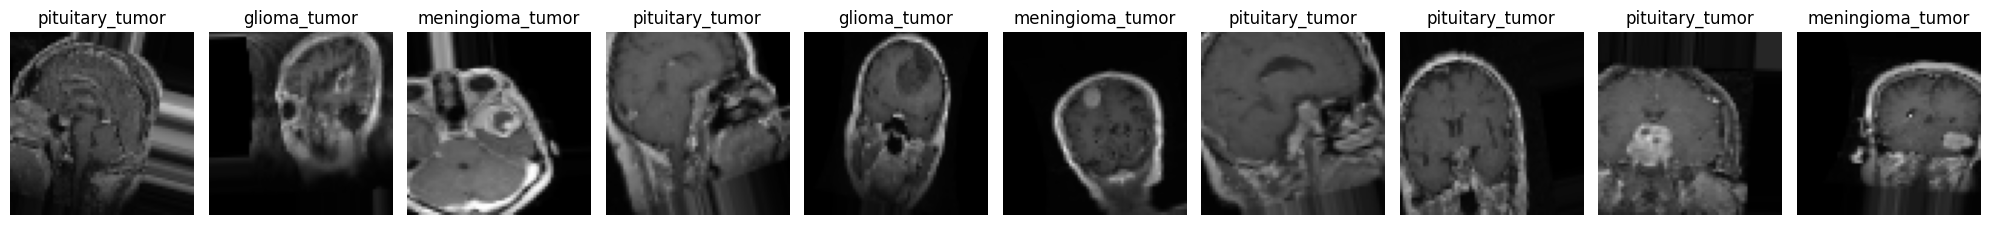

In [16]:
# Visualize training set images
train_images, train_labels = next(training_set)
plot_images(train_images[:10], train_labels[:10], list(training_set.class_indices.keys()))

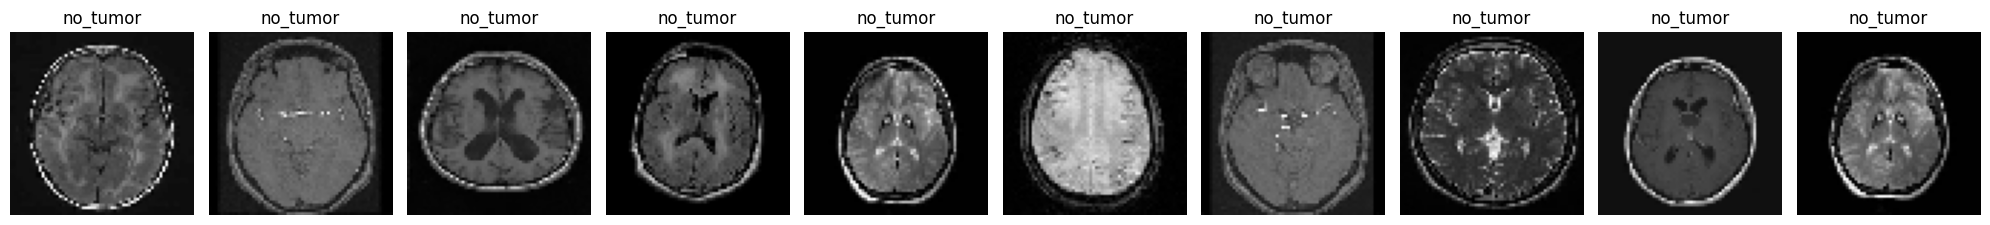

In [20]:
# Visualize test set images
test_images, test_labels = next(test_set)
plot_images(test_images[:10], test_labels[:10], list(test_set.class_indices.keys()))

In [10]:
def bottleneck_block(input_tensor, filters, weight_decay):
    x = tf.keras.layers.Conv2D(filters=filters//4, kernel_size=1, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(input_tensor)
    x = tf.keras.layers.Conv2D(filters=filters//4, kernel_size=3, padding='same', activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    return x

def model(weight_decay):
    input_tensor = tf.keras.layers.Input(shape=[64, 64, 3])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(input_tensor)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=1)(x)
    
    x = bottleneck_block(x, filters=32, weight_decay=weight_decay)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = bottleneck_block(x, filters=32, weight_decay=weight_decay)
    x = tf.keras.layers.MaxPool2D(pool_size=2, strides=1)(x)
    
    x = bottleneck_block(x, filters=32, weight_decay=weight_decay)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = bottleneck_block(x, filters=32, weight_decay=weight_decay)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
    output_tensor = tf.keras.layers.Dense(4, activation='softmax')(x)
    
    cnn = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)
    return cnn


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [12]:
def main():
    print("---------------------------Starting---------------------------")
    weight_decay = 1e-4  # Weight decay factor
    learning_rate = 1e-5  # Custom learning rate

    cnn = model(weight_decay)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("defined model, optimizer, and compilation done")
    print("------------defined model, optimizer, and compilation done----------------------")
    train_path = 'dataset\Training'
    test_path = 'dataset/Testing'
    train_datagen, test_datagen = datagen()

    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training directory not found: {train_path}")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Test directory not found: {test_path}")
    
    training_set, test_set = train_test_set(train_datagen, test_datagen, train_path, test_path)
    print("----------------------------training begin---------------------------")

    history = cnn.fit(x=training_set, validation_data=test_set, epochs=20, callbacks=[early_stopping])

    # Get predictions
    y_pred = np.argmax(cnn.predict(test_set), axis=1)
    y_true = test_set.classes  # Directly use the classes attribute
    print("----------------------------training end---------------------------")

if __name__ == '__main__':
    main()

---------------------------Starting---------------------------


KeyboardInterrupt: 